 # Collaborative Latent-Factors-Based Filtering for Movie Recommendations (Incomplete)

## Introduction

The latent factor approach in recommendation systems utilizes matrix factorization techniques to uncover hidden patterns in user-item interactions. These methods predict user preferences by mapping both users and items to a shared latent space where their interactions can be represented by their proximity or alignment. Latent factor models, such as Singular Value Decomposition (SVD), are widely used in this context.

Key features of the latent factor approach:
- Captures underlying relationships between users and items.
- Handles sparse datasets effectively by reducing dimensionality.
- Improves scalability compared to neighborhood-based methods.

In this notebook, we will explore the latent factor approach to build a movie recommendation system using matrix factorization.

### Mathematical Background

The latent factor approach works by:
- Represent users and items in a shared lower dimensional latent space (i.e., as a vector of latent factors).
- Such vectros are inferred (i.e., learned) from the observed ratings.
- High correlation between user and item latent factors indicates a possible recomendation.
- Map both users and items to the latent space and then predict ratings based on the inner product in the latent space.

So formally we have:
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $\vec x_u \in R^d$ is the latent factor vector for user $u$. Each $\vec x_u[k] \in R$ measure the extent of interest user $u$ has in items exhibiting latent factor $k$.
- $\vec w_i \in R^d$ is the latent factor vector for item $i$. Each $\vec w_i[k] \in R$ measure the extent of interest item $i$ has in users exhibiting latent factor $k$.

Essentially, $d$ hidden features to describe both users and items.

Thus, $r_{u,i}$ is the rating given by user $u$ to item $i$ and $\hat{r}_{u,i} = \vec x_u \cdot \vec w_i = \sum_{k=1}^d \vec x_u[k] \cdot \vec w_i[k]$ is the predicted rating for user $u$ and item $i$.

The problem is to approximate the user-item matrix $M \in \mathbb R^{n \times m}$ with the product of a user latent factor matrix $X \in \mathbb R^{n \times d}$ and an item latent factor matrix $W^T \in \mathbb R^{d \times m}$. So

$$
M \approx X \cdot W^T.
$$

## Dataset Description

We use two datasets for this analysis:

1. **Movies Dataset**:
   - `Movie_ID`: Unique identifier for each movie.
   - `Title`: Name of the movie.
   - `Year`: Year the movie was released.

2. **Ratings Dataset**:
   - `User_ID`: Unique identifier for each user.
   - `Movie_ID`: Identifier for the movie rated by the user.
   - `Rating`: Numeric rating provided by the user (e.g., on a scale of 1-5).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Load the datasets
movies_file = "/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Movie.csv"
ratings_file = "/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Rating.csv"

ratings = pd.read_csv(ratings_file)  # Columns: User_ID, Rating, Movie_ID
movies  = pd.read_csv(movies_file)    # Columns: Movie_ID, Year, Name

### Formal Definition

- $U = \{u_1, u_2, \dots, u_n\}$ is the set of users.
- $U_i = \{u \in U \mid r_{u,i} \neq 0\}$ is the set of users who have rated item $i$
- $I = \{i_1, i_2, \dots, i_m\}$ is the set of items.
- $I_u = \{i \in I \mid r_{u,i} \neq 0\}$ is the set of items rated by user $u$
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $r_{u,i}$ is the rating given by user $u$ for item $i$ (equal to 0 if not rated).
- $D = \{(u_j, i_j)\}_{j=1}^{N}$ is the set of user-item pairs (our dataset).
- $I_D = \{i \in I \mid \exists (u, i) \in D\}$ is the set of items in the dataset.
- $U_D = \{u \in U \mid \exists (u, i) \in D\}$ is the set of users in the dataset.

## User-Based Collaborative Filtering

### 1. Data Preprocessing
- **User-Item Matrix Creation**: Convert the ratings dataset into a user-item matrix, where rows represent users and columns represent movies. Missing ratings are filled with zeros. Each rating is represented by a number from 1 to 5.
  $$ M[u, i] = r_{u,i} \in R$$
  Where:
  - $u \in U$
  - $i \in I$
  - $r_{u,i}$ is the rating given by user $u$ for movie $i$.

- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format for memory optimization:
  $$M_{\{\text{sparse}\}} = \text{sparse}(M)$$

In [2]:
# Step 1: Create a user-item matrix
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating')

# Fill missing values with 0 (can use NaN for some algorithms)
user_item_matrix.fillna(0, inplace=True) # It is not the case for this dataset

# Convert the DataFrame to a sparse matrix
sparse_user_item = csr_matrix(user_item_matrix.values)

### 2. Determine the Loss Function and Computing Its Gradient

Assuming we have access to the dataset $D$ of observed ratings, the matrix $M$ is partially known and filled with those observations. To actually learn the latent factors, we need to choose a loss function to optimize. In our case, we choose squared error (SE):

$$
L(X, W) = \frac{1}{2} \left[ \sum_{(u, i) \in D} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\sum_{u \in U_D} \|\vec x_u\|^2 + \sum_{i \in I_D} \|\vec w_i\|^2)\right]
$$

Thus, 

$$X^*, W^* = \argmin_{X, W} \ L(X, W).$$

#### Loss Function
The loss function in matrix notation is defined in terms of matrices as:
$$
L(X, W) = \frac{1}{2} \left[ \| M - X W^T \|_F^2 + \lambda \left( \|X\|_F^2 + \|W\|_F^2 \right) \right],
$$
where:
- $M \in \mathbb{R}^{n \times m}$ is the observed rating matrix, with $M_{u,i} = r_{u,i}$ if user $u$ has rated item $i$, and 0 otherwise.
- $X \in \mathbb{R}^{n \times d}$ represents the user latent factors (each row corresponds to a user vector $X_u$).
- $W \in \mathbb{R}^{m \times d}$ represents the item latent factors (each row corresponds to an item vector $W_i$).
- $\| \cdot \|_F$ is the Frobenius norm.

The prediction matrix is:
$$
\hat{M} = X W^T.
$$

The loss consists of:
1. The reconstruction error:
$$
\| M - X W^T \|_F^2 = \sum_{(u, i) \in D} (r_{u,i} - X_u W_i^T)^2.
$$
2. The regularization terms:
$$
\lambda \left( \|X\|_F^2 + \|W\|_F^2 \right).
$$

---

#### Computing the Gradients

##### Gradient with respect to $X$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial X} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T) W.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial X} \frac{\lambda}{2} \|X\|_F^2 = \lambda X.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial X} = -(M - X W^T) W + \lambda X.
$$

---

##### Gradient with respect to $W$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial W} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T)^T X.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial W} \frac{\lambda}{2} \|W\|_F^2 = \lambda W.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial W} = -(M - X W^T)^T X + \lambda W.
$$

In [3]:
# Step 2: Setting up the model parameters

# Hyperparameters
num_factors = 500  # Number of latent factors (k)
learning_rate = 0.001  # Learning rate (eta)
reg_lambda = 0.0001  # Regularization term (lambda)
num_epochs = 25  # Number of epochs
gradient_clip = 10.0  # Gradient clipping threshold

# Dimensions of the user-item matrix
num_users, num_items = user_item_matrix.shape

# Create a mask for observed entries in R
M = user_item_matrix.values 
mask = M > 0  # Boolean mask for observed entries

### 3. Optimize the Loss Function with Stochastic Gradient Descent

In order to optimize the loss function, we use Stochastic Gradient Descent (SGD).

#### Explanation of the SGD Algorithm (Matrix Form)

##### 1. Initialization
- Matrices $X$ (users' latent factors) and $W$ (items' latent factors) are initialized randomly with small values.
- $X \in \mathbb{R}^{m \times d}$, where $m$ is the number of users and $d$ is the number of latent factors.
- $W \in \mathbb{R}^{n \times d}$, where $n$ is the number of items.

##### 2. Gradient Computation
- Define the prediction matrix:
  $$
  \hat{M} = X W^T
  $$
- Compute the error matrix (only for observed entries in $M$):
  $$
  E = \begin{cases}
  M_{ui} - \hat{M}_{ui} \quad &\text{if} \ M_{ui} > 0\\
  0 \quad &\text{otherwise}
  \end{cases},
  $$
  where $E_{ui} = 0$ for unobserved entries of $M$.

- Gradients for $X$ and $W$:
  $$
  \nabla_X = - E W + \lambda X
  $$
  $$
  \nabla_W = - E^T X + \lambda W
  $$

##### 3. Updates
- Update the latent factor matrices $X$ and $W$ simultaneously:
  $$
  X \leftarrow X - \eta \nabla_X
  $$
  $$
  W \leftarrow W - \eta \nabla_W
  $$
- Here, $\eta$ is the learning rate.

##### 4. Loss Tracking
- The total loss for each epoch combines the squared error and the regularization terms:
  $$
  L = \| M - X W^T \|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
  $$
- This tracks the reconstruction error and ensures that the latent factor matrices do not grow too large (controlled by the regularization term).

##### 5. Optimization Loop
- Repeat the following steps for a fixed number of epochs or until the loss converges:
  1. Compute the error matrix $E$.
  2. Compute the gradients $\nabla_X$ and $\nabla_W$ using matrix operations.
  3. Update $X$ and $W$ using the gradients.
  4. Track and print the loss for each epoch.

---

##### Notes
- This implementation only updates $X$ and $W$ for the observed entries of $M$ using matrix masking.
- The hyperparameters ($\eta$, $d$, and $\lambda$) should be tuned based on the dataset for optimal performance.

In [4]:
!pip install tqdm_joblib

In [5]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib  # Per gestire le barre di avanzamento con joblib

# Set the numpy seed
np.random.seed(42)

# Initialize X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# Loss history
loss_history = []

# Function to compute gradients for a single user (for X) or item (for W)
def compute_gradient_X(u):
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items]  # Subset of W for rated items
    M_rated = M[u, rated_items]  # Subset of M for rated items

    # Compute error and gradient for user u
    E_u = M_rated - X[u, :] @ W_rated.T
    grad = -E_u @ W_rated + reg_lambda * X[u, :]
    return np.clip(grad, -gradient_clip, gradient_clip)

def compute_gradient_W(i):
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users]  # Subset of X for rated users
    M_rated = M[rated_users, i]  # Subset of M for rated users

    # Compute error and gradient for item i
    E_i = M_rated - X_rated @ W[i, :].T
    grad = -E_i.T @ X_rated + reg_lambda * W[i, :]
    return np.clip(grad, -gradient_clip, gradient_clip)

# SGD Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Compute the predicted matrix
    M_hat = X @ W.T

    # Compute the error matrix for observed entries only
    E = np.multiply(mask, M - M_hat)

    # Parallel computation of gradients with progress bars
    grad_X = np.zeros_like(X)
    grad_W = np.zeros_like(W)

    # Update X with a shared progress bar
    print("  Updating X...")
    with tqdm_joblib(tqdm(desc="    Users", total=num_users, leave=True)) as _:
        grad_X = np.array(
            Parallel(n_jobs=-1)(delayed(compute_gradient_X)(u) for u in range(num_users))
        )

    # Update W with a shared progress bar
    print("  Updating W...")
    with tqdm_joblib(tqdm(desc="    Items", total=num_items, leave=True)) as _:
        grad_W = np.array(
            Parallel(n_jobs=-1)(delayed(compute_gradient_W)(i) for i in range(num_items))
        )

    # Apply updates
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss
    reconstruction_loss = np.sum(np.multiply(mask, E) ** 2)
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss

    # Append the total loss to the history
    loss_history.append(total_loss)

    # Print the loss for the current epoch
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

    # Debugging: Check mean and std of gradients
    print(f"  Gradient X: mean={np.mean(grad_X):.4f}, std={np.std(grad_X):.4f}")
    print(f"  Gradient W: mean={np.mean(grad_W):.4f}, std={np.std(grad_W):.4f}")

# Salvataggio delle matrici X e W in formato .npy
np.save("X_matrix_sgd.npy", X)
np.save("W_matrix_sgd.npy", W)

/usr/local/lib/python3.10/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Epoch 1/25
  Updating X...


    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...



    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 243096462.3088
  Regularization Loss: 0.7262
  Total Loss: 243096463.0350
  Gradient X: mean=0.0084, std=0.4144
  Gradient W: mean=0.1165, std=3.6522
Epoch 2/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [00:55<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 243053418.3649
  Regularization Loss: 0.7520
  Total Loss: 243053419.1170
  Gradient X: mean=0.1340, std=1.5435
  Gradient W: mean=0.2770, std=6.2456
Epoch 3/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:03<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 242411408.3125
  Regularization Loss: 0.9447
  Total Loss: 242411409.2572
  Gradient X: mean=0.2867, std=4.0940
  Gradient W: mean=0.7260, std=9.1469
Epoch 4/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:10<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 237562335.0480
  Regularization Loss: 1.6340
  Total Loss: 237562336.6820
  Gradient X: mean=0.5181, std=6.0663
  Gradient W: mean=0.7588, std=9.7679
Epoch 5/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:10<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 225019993.2948
  Regularization Loss: 3.1635
  Total Loss: 225019996.4583
  Gradient X: mean=0.6848, std=7.4315
  Gradient W: mean=0.9004, std=9.8096
Epoch 6/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [00:59<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 203741373.1447
  Regularization Loss: 5.7736
  Total Loss: 203741378.9182
  Gradient X: mean=0.7994, std=8.3832
  Gradient W: mean=0.9941, std=9.8838
Epoch 7/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:09<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 174153866.5805
  Regularization Loss: 9.6087
  Total Loss: 174153876.1891
  Gradient X: mean=0.8867, std=8.9441
  Gradient W: mean=0.9230, std=9.9149
Epoch 8/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:14<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 138460723.3090
  Regularization Loss: 14.7360
  Total Loss: 138460738.0450
  Gradient X: mean=0.9026, std=9.2442
  Gradient W: mean=1.0017, std=9.9266
Epoch 9/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:12<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 100206449.9647
  Regularization Loss: 21.1653
  Total Loss: 100206471.1301
  Gradient X: mean=0.9177, std=9.3632
  Gradient W: mean=0.9604, std=9.9340
Epoch 10/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:07<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 64072175.4263
  Regularization Loss: 28.7769
  Total Loss: 64072204.2032
  Gradient X: mean=0.9001, std=9.2502
  Gradient W: mean=0.9708, std=9.9393
Epoch 11/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:09<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 35807082.7497
  Regularization Loss: 36.3561
  Total Loss: 35807119.1058
  Gradient X: mean=0.7731, std=8.1297
  Gradient W: mean=0.9238, std=9.9134
Epoch 12/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:01<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 21187392.8787
  Regularization Loss: 39.4064
  Total Loss: 21187432.2850
  Gradient X: mean=0.2987, std=5.0098
  Gradient W: mean=0.3665, std=9.8047
Epoch 13/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [00:57<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 16618478.6564
  Regularization Loss: 39.7456
  Total Loss: 16618518.4020
  Gradient X: mean=0.0388, std=2.9289
  Gradient W: mean=0.2389, std=9.6632
Epoch 14/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:16<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 15385338.2808
  Regularization Loss: 40.6076
  Total Loss: 15385378.8884
  Gradient X: mean=0.0776, std=1.7242
  Gradient W: mean=0.1966, std=9.5634
Epoch 15/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:13<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 15059610.6525
  Regularization Loss: 40.0452
  Total Loss: 15059650.6977
  Gradient X: mean=-0.0485, std=1.7304
  Gradient W: mean=-0.1038, std=9.6867
Epoch 16/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:14<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14934156.3477
  Regularization Loss: 41.1525
  Total Loss: 14934197.5002
  Gradient X: mean=0.0967, std=1.5612
  Gradient W: mean=0.2344, std=9.5870
Epoch 17/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14828519.4725
  Regularization Loss: 40.2093
  Total Loss: 14828559.6818
  Gradient X: mean=-0.0830, std=1.8366
  Gradient W: mean=-0.2463, std=9.8420
Epoch 18/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14893911.9302
  Regularization Loss: 41.5494
  Total Loss: 14893953.4795
  Gradient X: mean=0.1169, std=1.9418
  Gradient W: mean=0.2799, std=9.8183
Epoch 19/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:09<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14741179.7065
  Regularization Loss: 40.4385
  Total Loss: 14741220.1450
  Gradient X: mean=-0.0985, std=2.0180
  Gradient W: mean=-0.2792, std=9.8912
Epoch 20/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:10<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14826796.3647
  Regularization Loss: 41.7966
  Total Loss: 14826838.1613
  Gradient X: mean=0.1177, std=2.0654
  Gradient W: mean=0.2962, std=9.9164
Epoch 21/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:10<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14654913.3441
  Regularization Loss: 40.6101
  Total Loss: 14654953.9542
  Gradient X: mean=-0.1058, std=2.0868
  Gradient W: mean=-0.2841, std=9.9191
Epoch 22/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14726544.6183
  Regularization Loss: 41.9489
  Total Loss: 14726586.5671
  Gradient X: mean=0.1151, std=2.0947
  Gradient W: mean=0.2968, std=9.9296
Epoch 23/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:00<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14547738.6911
  Regularization Loss: 40.7348
  Total Loss: 14547779.4259
  Gradient X: mean=-0.1090, std=2.1063
  Gradient W: mean=-0.2824, std=9.9183
Epoch 24/25
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:02<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14611226.8456
  Regularization Loss: 42.0588
  Total Loss: 14611268.9043
  Gradient X: mean=0.1128, std=2.1010
  Gradient W: mean=0.2977, std=9.9302
Epoch 25/25
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [01:13<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14425976.5319
  Regularization Loss: 40.8333
  Total Loss: 14426017.3652
  Gradient X: mean=-0.1108, std=2.1152
  Gradient W: mean=-0.2822, std=9.9194


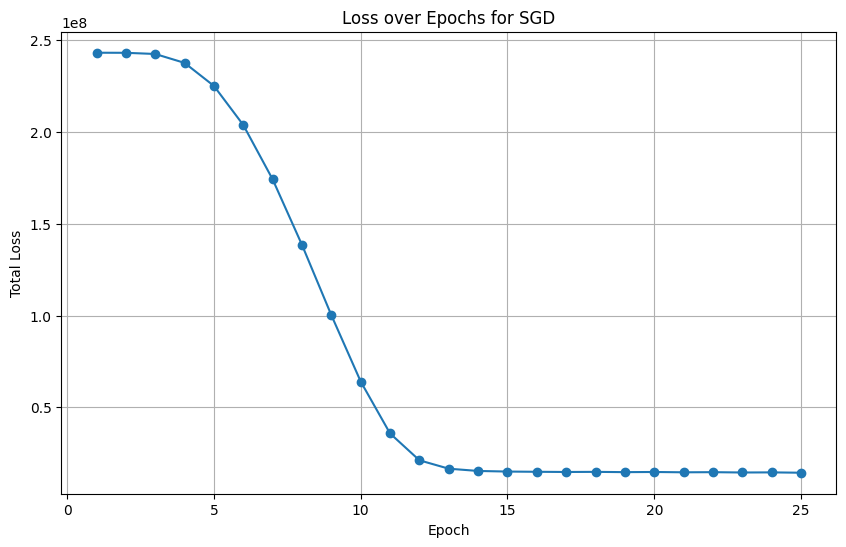

In [6]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for SGD')
plt.grid()
plt.show()

### Optimize the Loss Function with Alternating Least Squares (ALS)

Alternating Least Squares (ALS) is an optimization method for matrix factorization that alternates between updating the user latent factors ($X$) and the item latent factors ($W$).

#### Objective
The goal is to minimize the following loss function:
$$
L(X, W) = \|M - XW^T\|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
$$
Where:
- $M$: User-item interaction matrix.
- $X$: User latent factor matrix ($m \times k$).
- $W$: Item latent factor matrix ($n \times k$).
- $\lambda$: Regularization parameter.

#### ALS Algorithm
1. **Initialization**:
   - Start with random values for $X$ and $W$.
2. **Alternating Updates**:
   - Fix $W$, solve for $X$:
     $$
     X_u = (W^T W + \lambda I)^{-1} W^T M_u
     $$
   - Fix $X$, solve for $W$:
     $$
     W_i = (X^T X + \lambda I)^{-1} X^T M_i
     $$
3. **Convergence**:
   - Iterate until the loss stabilizes or a set number of epochs is reached.

In [7]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib  # Progress bars synchronized with joblib

# Set the numpy seed
np.random.seed(42)

num_epochs = 100  # Number of epochs

# Initialize X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# List to store the loss values for each iteration
loss_history = []

def update_user(u, W, M, mask, reg_lambda, num_factors):
    """Update a single user's latent factors."""
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items, :]
    M_rated = M[u, rated_items]
    
    A = W_rated.T @ W_rated + reg_lambda * np.eye(num_factors)
    b = W_rated.T @ M_rated
    return np.linalg.solve(A, b)

def update_item(i, X, M, mask, reg_lambda, num_factors):
    """Update a single item's latent factors."""
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users, :]
    M_rated = M[rated_users, i]
    
    A = X_rated.T @ X_rated + reg_lambda * np.eye(num_factors)
    b = X_rated.T @ M_rated
    return np.linalg.solve(A, b)

# ALS iterations
for iteration in range(num_epochs):
    print(f"Iteration {iteration + 1}/{num_epochs}")
    
    # Update X by fixing W (Parallelized) with synchronized progress bar
    print("  Updating X...")
    with tqdm_joblib(tqdm(desc="    Users", total=num_users, leave=True)) as _:
        X = np.array(Parallel(n_jobs=-1)(
            delayed(update_user)(u, W, M, mask, reg_lambda, num_factors) for u in range(num_users)
        ))
    
    # Update W by fixing X (Parallelized) with synchronized progress bar
    print("  Updating W...")
    with tqdm_joblib(tqdm(desc="    Items", total=num_items, leave=True)) as _:
        W = np.array(Parallel(n_jobs=-1)(
            delayed(update_item)(i, X, M, mask, reg_lambda, num_factors) for i in range(num_items)
        ))
    
    # Compute the loss
    M_hat = X @ W.T
    reconstruction_loss = np.sum(np.multiply(mask, (M - M_hat) ** 2))
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss
    
    # Save the loss in history
    loss_history.append(total_loss)
    
    # Print loss for the current iteration
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

# Salvataggio delle matrici X e W in formato .npy
np.save("X_matrix_als.npy", X)
np.save("W_matrix_als.npy", W)

Iteration 1/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:01<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 443436.9995
  Regularization Loss: 827074.6844
  Total Loss: 1270511.6839
Iteration 2/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:58<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 149517.7179
  Regularization Loss: 723520.8374
  Total Loss: 873038.5553
Iteration 3/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:28<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 85755.7267
  Regularization Loss: 698221.6013
  Total Loss: 783977.3280
Iteration 4/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:52<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 58759.4516
  Regularization Loss: 684814.0187
  Total Loss: 743573.4703
Iteration 5/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:59<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 43620.0193
  Regularization Loss: 674379.8685
  Total Loss: 717999.8878
Iteration 6/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:24<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 34141.4574
  Regularization Loss: 665529.3960
  Total Loss: 699670.8533
Iteration 7/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:47<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 27763.7203
  Regularization Loss: 657696.5505
  Total Loss: 685460.2708
Iteration 8/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:14<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 23236.6359
  Regularization Loss: 650577.2541
  Total Loss: 673813.8900
Iteration 9/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:34<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 19885.0855
  Regularization Loss: 643986.7166
  Total Loss: 663871.8021
Iteration 10/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:10<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 17317.2305
  Regularization Loss: 637804.9184
  Total Loss: 655122.1489
Iteration 11/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:24<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 15292.8283
  Regularization Loss: 631950.3417
  Total Loss: 647243.1700
Iteration 12/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:34<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13658.0356
  Regularization Loss: 626365.6427
  Total Loss: 640023.6783
Iteration 13/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:59<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 12310.7403
  Regularization Loss: 621009.2519
  Total Loss: 633319.9922
Iteration 14/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:30<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 11181.0585
  Regularization Loss: 615850.2097
  Total Loss: 627031.2682
Iteration 15/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:27<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 10219.8565
  Regularization Loss: 610864.8797
  Total Loss: 621084.7361
Iteration 16/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:28<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 9391.7432
  Regularization Loss: 606034.7969
  Total Loss: 615426.5401
Iteration 17/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:07<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 8670.6581
  Regularization Loss: 601345.2263
  Total Loss: 610015.8844
Iteration 18/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:25<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 8037.0188
  Regularization Loss: 596784.1760
  Total Loss: 604821.1948
Iteration 19/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:58<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 7475.8340
  Regularization Loss: 592341.7095
  Total Loss: 599817.5436
Iteration 20/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:59<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 6975.4295
  Regularization Loss: 588009.4572
  Total Loss: 594984.8867
Iteration 21/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:23<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 6526.5704
  Regularization Loss: 583780.2639
  Total Loss: 590306.8343
Iteration 22/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:14<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 6121.8465
  Regularization Loss: 579647.9310
  Total Loss: 585769.7775
Iteration 23/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:16<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 5755.2342
  Regularization Loss: 575607.0242
  Total Loss: 581362.2584
Iteration 24/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 5421.7795
  Regularization Loss: 571652.7289
  Total Loss: 577074.5085
Iteration 25/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:16<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 5117.3650
  Regularization Loss: 567780.7398
  Total Loss: 572898.1049
Iteration 26/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:14<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4838.5357
  Regularization Loss: 563987.1752
  Total Loss: 568825.7109
Iteration 27/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:52<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4582.3678
  Regularization Loss: 560268.5101
  Total Loss: 564850.8779
Iteration 28/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:51<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4346.3683
  Regularization Loss: 556621.5231
  Total Loss: 560967.8914
Iteration 29/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:21<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4128.3963
  Regularization Loss: 553043.2539
  Total Loss: 557171.6503
Iteration 30/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:17<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3926.6022
  Regularization Loss: 549530.9689
  Total Loss: 553457.5711
Iteration 31/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3739.3788
  Regularization Loss: 546082.1327
  Total Loss: 549821.5115
Iteration 32/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:55<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3565.3222
  Regularization Loss: 542694.3850
  Total Loss: 546259.7072
Iteration 33/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:51<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3403.2007
  Regularization Loss: 539365.5209
  Total Loss: 542768.7217
Iteration 34/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:17<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3251.9286
  Regularization Loss: 536093.4748
  Total Loss: 539345.4034
Iteration 35/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:18<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3110.5450
  Regularization Loss: 532876.3060
  Total Loss: 535986.8510
Iteration 36/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:17<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2978.1967
  Regularization Loss: 529712.1870
  Total Loss: 532690.3837
Iteration 37/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:50<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2854.1230
  Regularization Loss: 526599.3932
  Total Loss: 529453.5162
Iteration 38/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:49<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2737.6440
  Regularization Loss: 523536.2936
  Total Loss: 526273.9376
Iteration 39/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:04<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2628.1496
  Regularization Loss: 520521.3436
  Total Loss: 523149.4931
Iteration 40/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:20<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2525.0911
  Regularization Loss: 517553.0772
  Total Loss: 520078.1683
Iteration 41/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:13<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2427.9738
  Regularization Loss: 514630.1017
  Total Loss: 517058.0755
Iteration 42/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:47<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2336.3502
  Regularization Loss: 511751.0917
  Total Loss: 514087.4420
Iteration 43/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:48<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2249.8149
  Regularization Loss: 508914.7847
  Total Loss: 511164.5996
Iteration 44/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2167.9994
  Regularization Loss: 506119.9761
  Total Loss: 508287.9755
Iteration 45/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:18<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2090.5686
  Regularization Loss: 503365.5158
  Total Loss: 505456.0844
Iteration 46/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:15<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2017.2166
  Regularization Loss: 500650.3044
  Total Loss: 502667.5209
Iteration 47/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:02<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1947.6638
  Regularization Loss: 497973.2900
  Total Loss: 499920.9538
Iteration 48/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:57<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1881.6543
  Regularization Loss: 495333.4652
  Total Loss: 497215.1195
Iteration 49/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:23<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1818.9535
  Regularization Loss: 492729.8644
  Total Loss: 494548.8179
Iteration 50/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:55<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1759.3458
  Regularization Loss: 490161.5614
  Total Loss: 491920.9072
Iteration 51/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:23<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1702.6327
  Regularization Loss: 487627.6669
  Total Loss: 489330.2997
Iteration 52/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:02<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1648.6317
  Regularization Loss: 485127.3267
  Total Loss: 486775.9584
Iteration 53/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:00<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1597.1739
  Regularization Loss: 482659.7196
  Total Loss: 484256.8934
Iteration 54/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:25<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1548.1036
  Regularization Loss: 480224.0553
  Total Loss: 481772.1589
Iteration 55/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:53<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1501.2767
  Regularization Loss: 477819.5736
  Total Loss: 479320.8502
Iteration 56/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:17<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1456.5596
  Regularization Loss: 475445.5417
  Total Loss: 476902.1013
Iteration 57/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:03<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1413.8285
  Regularization Loss: 473101.2538
  Total Loss: 474515.0823
Iteration 58/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:01<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1372.9685
  Regularization Loss: 470786.0290
  Total Loss: 472158.9975
Iteration 59/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:34<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1333.8727
  Regularization Loss: 468499.2106
  Total Loss: 469833.0834
Iteration 60/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:30<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1296.4418
  Regularization Loss: 466240.1646
  Total Loss: 467536.6064
Iteration 61/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:54<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1260.5832
  Regularization Loss: 464008.2786
  Total Loss: 465268.8617
Iteration 62/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:32<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1226.2105
  Regularization Loss: 461802.9609
  Total Loss: 463029.1714
Iteration 63/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:46<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [04:41<?, ?it/s]


  Reconstruction Loss: 1193.2433
  Regularization Loss: 459623.6396
  Total Loss: 460816.8829
Iteration 64/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:03<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1161.6063
  Regularization Loss: 457469.7615
  Total Loss: 458631.3678
Iteration 65/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:50<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1131.2293
  Regularization Loss: 455340.7915
  Total Loss: 456472.0208
Iteration 66/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:43<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1102.0465
  Regularization Loss: 453236.2113
  Total Loss: 454338.2578
Iteration 67/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:02<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1073.9963
  Regularization Loss: 451155.5194
  Total Loss: 452229.5157
Iteration 68/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:59<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1047.0210
  Regularization Loss: 449098.2298
  Total Loss: 450145.2508
Iteration 69/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:24<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1021.0665
  Regularization Loss: 447063.8713
  Total Loss: 448084.9379
Iteration 70/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:21<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 996.0820
  Regularization Loss: 445051.9875
  Total Loss: 446048.0696
Iteration 71/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:50<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 972.0199
  Regularization Loss: 443062.1355
  Total Loss: 444034.1554
Iteration 72/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:16<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 948.8352
  Regularization Loss: 441093.8856
  Total Loss: 442042.7208
Iteration 73/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:45<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [04:33<?, ?it/s]


  Reconstruction Loss: 926.4857
  Regularization Loss: 439146.8209
  Total Loss: 440073.3066
Iteration 74/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:57<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 904.9319
  Regularization Loss: 437220.5365
  Total Loss: 438125.4684
Iteration 75/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:43<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 884.1363
  Regularization Loss: 435314.6393
  Total Loss: 436198.7756
Iteration 76/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:19<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 864.0637
  Regularization Loss: 433428.7474
  Total Loss: 434292.8111
Iteration 77/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:17<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 844.6809
  Regularization Loss: 431562.4896
  Total Loss: 432407.1705
Iteration 78/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:44<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 825.9565
  Regularization Loss: 429715.5052
  Total Loss: 430541.4617
Iteration 79/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:49<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 807.8608
  Regularization Loss: 427887.4434
  Total Loss: 428695.3042
Iteration 80/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:24<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 790.3660
  Regularization Loss: 426077.9629
  Total Loss: 426868.3289
Iteration 81/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:06<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 773.4456
  Regularization Loss: 424286.7318
  Total Loss: 425060.1774
Iteration 82/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:25<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 757.0745
  Regularization Loss: 422513.4271
  Total Loss: 423270.5016
Iteration 83/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:28<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 741.2291
  Regularization Loss: 420757.7343
  Total Loss: 421498.9634
Iteration 84/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:05<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 725.8870
  Regularization Loss: 419019.3471
  Total Loss: 419745.2341
Iteration 85/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:41<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 711.0269
  Regularization Loss: 417297.9674
  Total Loss: 418008.9943
Iteration 86/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:13<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 696.6287
  Regularization Loss: 415593.3045
  Total Loss: 416289.9332
Iteration 87/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:47<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 682.6732
  Regularization Loss: 413905.0754
  Total Loss: 414587.7487
Iteration 88/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:22<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 669.1425
  Regularization Loss: 412233.0042
  Total Loss: 412902.1466
Iteration 89/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:56<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 656.0191
  Regularization Loss: 410576.8217
  Total Loss: 411232.8409
Iteration 90/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [07:24<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 643.2869
  Regularization Loss: 408936.2657
  Total Loss: 409579.5526
Iteration 91/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:57<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 630.9302
  Regularization Loss: 407311.0804
  Total Loss: 407942.0105
Iteration 92/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:00<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 618.9342
  Regularization Loss: 405701.0159
  Total Loss: 406319.9502
Iteration 93/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:48<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [04:46<?, ?it/s]


  Reconstruction Loss: 607.2850
  Regularization Loss: 404105.8289
  Total Loss: 404713.1139
Iteration 94/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [03:06<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 595.9691
  Regularization Loss: 402525.2815
  Total Loss: 403121.2506
Iteration 95/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [08:12<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 584.9738
  Regularization Loss: 400959.1416
  Total Loss: 401544.1154
Iteration 96/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [02:08<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 574.2870
  Regularization Loss: 399407.1827
  Total Loss: 399981.4697
Iteration 97/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:36<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 563.8970
  Regularization Loss: 397869.1833
  Total Loss: 398433.0804
Iteration 98/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Items:   0%|          | 0/1350 [01:59<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 553.7929
  Regularization Loss: 396344.9275
  Total Loss: 396898.7204
Iteration 99/100
  Updating X...




    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:25<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 543.9642
  Regularization Loss: 394834.2038
  Total Loss: 395378.1680
Iteration 100/100
  Updating X...



    Users:   0%|          | 0/143458 [00:00<?, ?it/s]

  0%|          | 0/143458 [00:00<?, ?it/s]

    Users:   0%|          | 0/143458 [06:21<?, ?it/s]


  Updating W...


    Items:   0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 534.4007
  Regularization Loss: 393336.8060
  Total Loss: 393871.2067


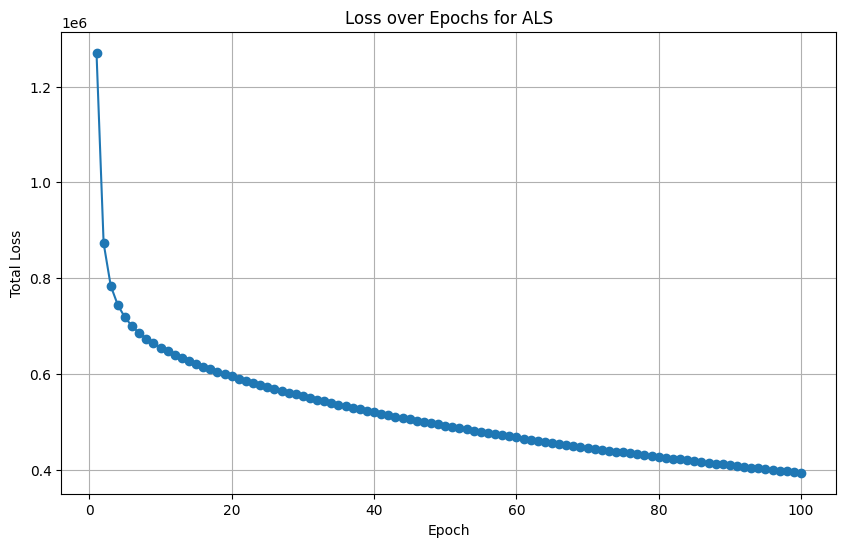

In [8]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for ALS')
plt.grid()
plt.show()

In [9]:
def recommend_movies(user_id, M_hat, user_item_matrix, movies, top_n=10):
    """
    Recommends movies for a given user based on the predicted matrix M_hat.

    Parameters:
    - user_id: ID of the user to whom the recommendations will be made.
    - M_hat: Predicted user-item matrix (num_users x num_items).
    - user_item_matrix: Original user-item matrix (Pandas DataFrame) with ratings.
    - movies: DataFrame containing movie details (Movie_ID, Name, Year).
    - top_n: Number of recommendations to return (default is 10).

    Returns:
    - recommendations: DataFrame containing the top_n recommended movies.
    """
    # Map user_id to the corresponding index in M_hat
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Get the predicted ratings for the user
    predicted_ratings = M_hat[user_index]

    # Get the user's original ratings
    original_ratings = user_item_matrix.loc[user_id]

    # Find movies that the user has not rated (those with a rating of 0)
    unrated_movies = original_ratings[original_ratings == 0].index

    # Map the unrated movies to the correct columns in M_hat
    unrated_predictions = {
        movie_id: predicted_ratings[user_item_matrix.columns.get_loc(movie_id)]
        for movie_id in unrated_movies
    }

    # Sort the predicted ratings for unrated movies in descending order
    sorted_predictions = sorted(unrated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Get the top_n movie IDs
    top_movie_ids = [movie_id for movie_id, _ in sorted_predictions[:top_n]]

    # Retrieve movie details for the top_n recommendations
    recommendations = movies[movies['Movie_ID'].isin(top_movie_ids)]

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    recommendations = recommendations.copy()
    
    # Add the Predicted_Rating column
    recommendations['Predicted_Rating'] = [unrated_predictions[movie_id] for movie_id in recommendations['Movie_ID']]
    
    # Sort recommendations by predicted rating (optional, for clarity)
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)

    return recommendations[['Movie_ID', 'Name', 'Year', 'Predicted_Rating']]

### 4. Model Testing
The function is tested with a sample user to generate personalized recommendations.

In [10]:
# Step 4: Test the recommendation function
user_id_to_test = 774868  # Cambia con un ID utente valido nel dataset
num_recommendations = 5   # Numero di raccomandazioni desiderate

try:
    # Esegui la funzione di raccomandazione
    recommendations = recommend_movies(user_id_to_test, M_hat, user_item_matrix, movies, top_n=num_recommendations)
    
    # Mostra i risultati
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test}:")
    print(recommendations[['Name', 'Year', 'Predicted_Rating', 'Movie_ID']])
except KeyError as e:
    print(f"Error: User ID {user_id_to_test} not found in the dataset.")
except ValueError as e:
    print(f"Error: {e}")

Top 5 movie recommendations for User 774868:
                            Name  Year  Predicted_Rating  Movie_ID
2944                          10  1979          2.651704      2945
2301                    Clockers  1995          2.361884      2302
4247         Conan the Barbarian  1981          2.346736      4248
3182  King of the Hill: Season 3  1998          2.278184      3183
1209                       Zorro  1981          2.259813      1210
